In [ ]:
%pip install networkx
%pip install matplotlib

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools

In [112]:
l = 5
w = 2*l-1
lattice = nx.Graph()
lattice.add_nodes_from([(n, m) for n in range(w) for m in range(w)])
# all horizontal/vertical edges
vertex_edges = [((2*n+1, m), (2*n+1, (m+1)%w)) for n in range(l-1) for m in range(2*l-1)] + \
                         [((n, 2*m), ((n+1)%w, 2*m)) for n in range(2*l-1) for m in range(l)]
lattice.add_edges_from(vertex_edges)
# plaquette_edges = [((2*n+1, m), (2*n+1, (m+1)%(2*l))) for n in range(l) for m in range(2*l)] + \
#                          [((n, 2*m+1), ((n+1)%(2*l), 2*m+1)) for n in range(2*l) for m in range(l)]
# lattice.add_edges_from(plaquette_edges)
# inter-qubit edges only
inter_qubit_edges = []
for ns in range(0, 2*w, 2):
    i = min(ns, w-1)
    j = ns-i
    while j < w-1 and i > 0:
        inter_qubit_edges.append(((i,j),(i-1,j+1)))
        i -= 1
        j += 1
for df in range(-2*(l-1), 2*l, 2):
    i = max(0, df)
    j = i-df
    while j < w-1 and i < w-1:
        inter_qubit_edges.append(((i,j), (i+1, j+1)))
        i += 1
        j += 1
lattice.add_edges_from(inter_qubit_edges)

# Nodes/edges to check for loops
# x_terminals = [(1, -1), (1, 2*l)]
# lattice.add_nodes_from(x_terminals)
# x_terminal_edges = [(x_terminals[0], (2*n,1)) for n in range(l)] + [((2*n, 2*l-1), x_terminals[1]) for n in range(l)]
# lattice.add_edges_from(x_terminal_edges)



qubit_coordinates = [(2*n, 2*m) for n in range(l) for m in range(l)] + [(2*n+1, 2*m+1) for n in range(l-1) for m in range(l-1)]
vertex_coordinates = {(2*n+1, 2*m):1 for n in range(l) for m in range(l)}
# plaquette_coordinates = [(2*n+1, 2*m+1) for n in range(l) for m in range(l)] 
lattice_qubits = lattice.subgraph(qubit_coordinates)
lattice_vis = lattice.subgraph(qubit_coordinates + list(vertex_coordinates.keys()))
lattice_vertex = lattice.subgraph(list(vertex_coordinates.keys()))
# lattice_plaquette = lattice.subgraph(plaquette_coordinates)

num_phys_qubits = len(lattice_qubits.nodes())
print(f"Number of physical qubits needed = {num_phys_qubits}")


Number of physical qubits needed = 41


In [106]:
0

0

### Plot a graph of the surface code
Red = Physical qubit, Green = Vertex, Blue = Plaquette

Reminder: Plaquettes are stabilizers for Z-ops and vertices are stabilizers for X-ops

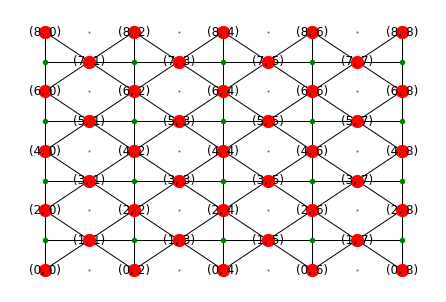

In [114]:
pos = {(x,y):(y,x) for x,y in lattice.nodes()}
# nx.draw(lattice, pos=pos, node_size = 3) edgelist=vertex_edges,
nx.draw(lattice, pos=pos, node_size = 1)
nx.draw(lattice_qubits, with_labels=True, pos=pos, edgelist=[], node_color = 'r', node_size = 150)
nx.draw(lattice_vertex, pos=pos, node_color = 'g', node_size = 20)
# nx.draw(lattice_plaquette, pos=pos, node_color = 'b', node_size = 10)

Before we begin let's compute all-pairs shortest paths

In [115]:
shortest_paths = dict(nx.all_pairs_shortest_path(lattice_vis))

Ok lets simulate catching Z errors. These will be caught by the vertex stabilizers

In [122]:
from numpy.random import uniform
prob = 0.2 # Error rate for physical qubit

# Let's store two arrays for each offset grid of qubits
qubits_flipped = {qc: (0 if uniform()>prob else 1) for qc in qubit_coordinates}

# calculate stabilizer eigenvalues

def bounds(q):
    x,y = q
    return x >= 0 and x < w and y >= 0 and y < w

def calculate_stabilizer_eigenvalues(qubits_flipped, vertex_coordinates):
    for k in vertex_coordinates.keys():
        vertex_coordinates[k] = 1
        # print(f"vertex = {k}", end=" -- ")
        for offs in [(1,0), (-1,0), (0,1), (0,-1)]:
            qubit = ((k[0]+offs[0]), (k[1]+offs[1]))
            # print(qubit, end=", ")
            if bounds(qubit) and qubits_flipped[qubit] == 1:
                vertex_coordinates[k] *= -1
        # print()

calculate_stabilizer_eigenvalues(qubits_flipped, vertex_coordinates)
# print(vertex_coordinates)

Lets check if any of this makes sense

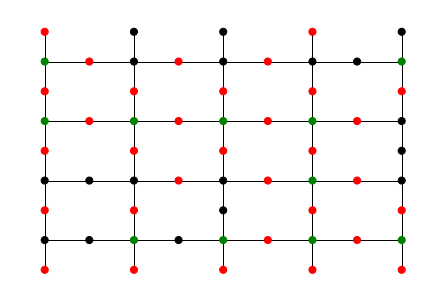

In [123]:
colour_qubits = ['red' if qubits_flipped[q] == 0 else 'black' for q in lattice_qubits]
colour_vertices = ['green' if vertex_coordinates[q] == 1 else 'black' for q in lattice_vertex]
nx.draw(lattice_vis, pos=pos, edgelist=vertex_edges, node_size = 1)
nx.draw_networkx_nodes(lattice_qubits, pos=pos, node_color=colour_qubits, node_size=50)
nx.draw_networkx_nodes(lattice_vertex, pos=pos, node_color=colour_vertices, node_size=50);

In the above graph, physical qubits that are not flipped are red, and the ones that are flipped are black. For the vertices, green means that the eigenvalue is +1 and black means that the eigenvalue is -1. We can see that the flipped physical qubits form a chain that joins two syndromes (ie vertices with -1 eigenvalue)

To make networkx compute MWPM we must do some cleanup - we must construct the graph of just the syndromes

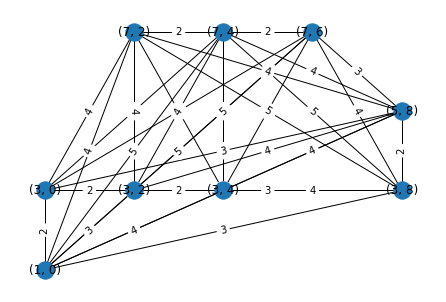

In [124]:
syndromes = [q for q in lattice_vertex if vertex_coordinates[q] == -1]
syndrome_edges = [(p1, p2, {'weight': len(shortest_paths[p1][p2])-1}) for i,p1 in enumerate(syndromes) for j,p2 in enumerate(syndromes) if i>j]
syndrome_G = nx.Graph()
syndrome_G.add_nodes_from(syndromes)
syndrome_G.add_edges_from(syndrome_edges)
nx.draw(syndrome_G, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(syndrome_G, pos=pos, edge_labels=nx.get_edge_attributes(syndrome_G,'weight'));

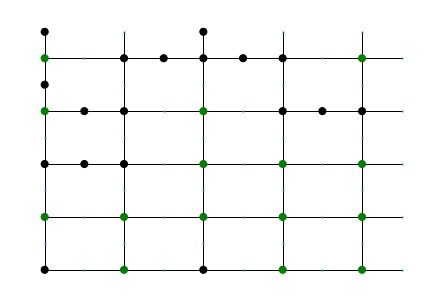

In [242]:
def qubits_from_path(nodes):
    return [n for n in nodes if n[0]%2 == 1 or n[1]%2==1]


matching = list(nx.min_weight_matching(syndrome_G, weight='weight'))
syndrome_corrections = list(itertools.chain.from_iterable(qubits_from_path(shortest_paths[s][e]) for s,e in matching))
# colour_qubits_correction = ['red' if qubits_flipped[q] == 0 else 'purple' for q in lattice_qubits]
size_qubits_correction = [0 if qubits_flipped[q] == 0 else 50 for q in lattice_qubits]
nx.draw(lattice_vis, pos=pos, edgelist=vertex_edges, node_size = 1)
nx.draw_networkx_nodes(lattice_qubits, pos=pos, node_color='black', node_size=size_qubits_correction)
nx.draw_networkx_nodes(lattice_vertex, pos=pos, node_color=colour_vertices, node_size=50);

Calculate corrected system

In [243]:
for q in syndrome_corrections:
    qubits_flipped[q] = 1-qubits_flipped[q]
calculate_stabilizer_eigenvalues(qubits_flipped, vertex_coordinates)    

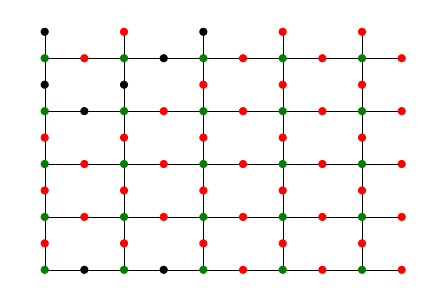

In [246]:
colour_qubits = ['red' if qubits_flipped[q] == 0 else 'black' for q in lattice_qubits]
colour_vertices = ['green' if vertex_coordinates[q] == 1 else 'black' for q in lattice_vertex]
nx.draw(lattice_vis, pos=pos, edgelist=vertex_edges, node_size = 1)
nx.draw_networkx_nodes(lattice_qubits, pos=pos, node_color=colour_qubits, node_size=50)
nx.draw_networkx_nodes(lattice_vertex, pos=pos, node_color=colour_vertices, node_size=50)

qubit connectivity graph to check for loop

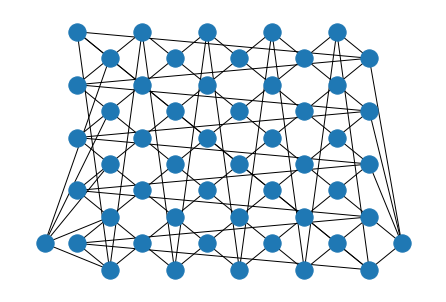

In [247]:

nx.draw(lattice.subgraph(qubit_coordinates+x_terminals), pos=pos)

In [248]:
nx.has_path(lattice.subgraph(qubit_coordinates+x_terminals), x_terminals[0], x_terminals[1])

True